# Homework 1: Quantum Wells and Perturbation Theory

---
## Introduction
In this homework you will:
- Work with quantum wells
- Implement a Schrödinger solver
- Explore perturbation theory



In [32]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.constants as const
from scipy.sparse import diags
from scipy.sparse.linalg import eigsh

SciPy Docs: https://docs.scipy.org/doc/scipy/reference/
NumPy Docs: https://numpy.org/doc/stable/reference/routines.array-manipulation.html
## Cell: imports - breakdown
- `import numpy as np`: Array operations, np.array converts lists to arrays.
- `scipy constant as const`: Used to provide precise physical constants (charge of electron)
- `scipy.sparse import diags`: Function creates sparse diagonal matrices. (diagonal elements -> sparse matrices)
- `scipy.sparse.linalg import eigsh`: sparse linear algebra, function to find eigenvalues and eigenvectors of large, sparse matrices.


### Helper Functions
The following function builds a heterostructure potential.
Layers are defined as `(thickness, band_edge)`, whereas the thickness is passed in nanometers and the band-edge in eV. 
Returns: Two arrays, the first being the grid in space and the second the potential structure.

Example: `[(5, 1.0), (2, 0.3), (5, 1.0)]` → barrier-well-barrier structure.

Tip: Use the function and plot a random structure to understand it.

In [33]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.constants as const

def build_potential(layers, dz_nm=0.05):
    """
    Build heterostructure potential from layers.
    layers: list of (thickness [nm], band edge [eV])
    dz_nm: grid spacing [nm]
    returns: z [m], V [J]
    """
    z = [] #Initialize empty list for spatial coordinates 
    V = [] #Initialize empty list por potential val
    pos = 0.0 # x, y 0.0
    for thickness_nm, band_edge_eV in layers:
        n_points = int(thickness_nm/dz_nm) # calc the num of discrete points for the current layer
        for _ in range(n_points): # (5, 1.0) == (thickness, band_edge)
            z.append(pos * 1e-9) # append current pos to the z list. layers are a list of objects, appending (to tail) each point leads to vectorization
            V.append(band_edge_eV * const.eV) # append layers band edge to the V list
            pos += dz_nm # dz_nm grid spacing, so it moves one grid space per iteration
    return np.array(z), np.array(V) #creates arr

## Task 1: Finite Quantum Well
**(a)** Use `build_potential` to make a single well of width 3 nm, band edge offset 1 eV. 

**(b)** Solve numerically. Implement the function `solve_schrodinger(z, V, n_eigs)` that:
- Constructs the Hamiltonian with finite differences
- Uses electron mass `m_e`
- Returns the lowest `n_eigs` eigenenergies (in eV)
- Returns normalized wavefunctions (∫ |ψ|² dx = 1)

Use as boundary condition that the wavefunction must be zero. Consider this when you choose a barrier material layer thickness to not introduce numerical artifacts.

**(c)** Plot probability densities for first three states and compare energies with analytical values. Maybe use a scaling factor for the wavefunction such that the wavefunction is nicely plotted. Use axis labels (incl. units) and a legend where helpful. 

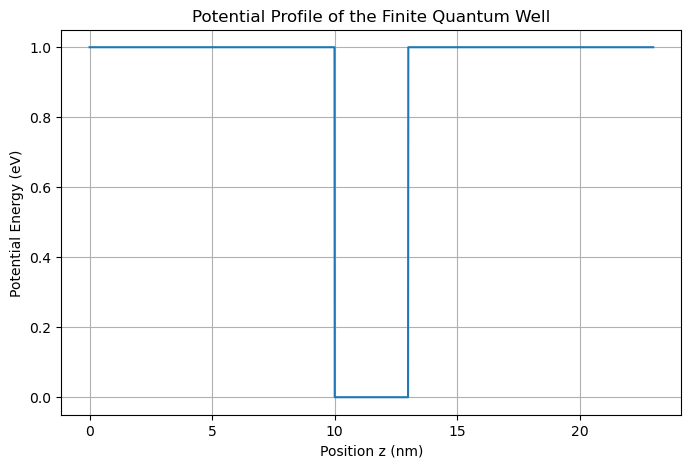

In [34]:
# Task 1a: Define the quantum well structure
# [(thickness_nm, potential_eV), ...]
well_width_nm = 3.0
barrier_width_nm = 10.0
barrier_height_eV = 1.0

# Structure: Barrier - Well - Barrier
layers_task1 = [
    (barrier_width_nm, barrier_height_eV),
    (well_width_nm, 0.0),
    (barrier_width_nm, barrier_height_eV)
]

# Grid spacing in nanometers
dz_nm = 0.01

# Build the potential using the helper function
z, V = build_potential(layers_task1, dz_nm=dz_nm)

# Plot the potential to verify
plt.figure(figsize=(8, 5))
plt.plot(z * 1e9, V / const.eV)
plt.title('Potential Profile of the Finite Quantum Well')
plt.xlabel('Position z (nm)')
plt.ylabel('Potential Energy (eV)')
plt.grid(True)
plt.show()

This cell models the physics of a quantum well, which is an energy trap for electrons formed by sandwiching a low-potential material between two high-potential barriers.
We use the custom build_potential function to translate this layered structure into a numerical array and matplotlib.pyplot.plot to visualize it.
The output plot shows a rectangle "dip" in potential energy, which is the well where a particle can be confined. https://en.wikipedia.org/wiki/Potential_well "Quantum confinement"



In [45]:
def solve_schrodinger(z, V, n_eigsh=5):
    """
    Solves the 1D time-independent Schrödinger equation numerically.

    Args:
        z (np.array): The spatial grid in meters.
        V (np.array): The potential energy at each grid point in Joules.
        n_eigsh (int): The number of lowest eigenvalues/eigenstates to compute.

    Returns:
        tuple: A tuple containing:
               - energies (np.array): The lowest n_eigs eigenvalues in eV.
               - wavefunctions (np.array): The corresponding normalized wavefunctions.
    """
    # Calculate grid spacing from the z-array
    dz = z[1] - z[0]
    N = len(z) # Number of grid points

    # Kinetic energy term constant
    T_const = -const.hbar**2 / (2 * const.m_e * dz**2)

    # Construct the main diagonal for the kinetic part of the Hamiltonian
    main_diag = -2 * np.ones(N)
    # Construct the off-diagonals for the kinetic part
    off_diag = np.ones(N - 1)

    # Create the sparse tridiagonal matrix for the kinetic energy operator
    # The diags function takes a list of diagonals and their positions
    # 0 for the main diagonal, -1 and 1 for the sub- and super-diagonals
    diagonals = [main_diag, off_diag, off_diag]
    T = T_const * diags(diagonals, [0, -1, 1], shape=(N, N), format='csc')

    # The potential energy operator is a diagonal matrix with V on the diagonal
    U = diags([V], [0], shape=(N, N), format='csc')

    # The total Hamiltonian is the sum of kinetic and potential energy operators
    H = T + U

    # Solve the eigenvalue problem H*psi = E*psi
    # eigs finds the k largest/smallest eigenvalues of a sparse matrix.
    # 'SM' stands for Smallest Magnitude, which gives us the lowest energy states.
    eigenvalues, eigenvectors = eigsh(H, k=n_eigsh, which='SA')

    # Sort the eigenvalues and corresponding eigenvectors in ascending order
    sorted_indices = np.argsort(eigenvalues)
    energies_J = np.real(eigenvalues[sorted_indices])
    wavefunctions = np.real(eigenvectors[:, sorted_indices])

    # Normalize the wavefunctions such that ∫|ψ|² dz = 1
    for i in range(n_eigsh):
        psi = wavefunctions[:, i]
        norm_const = np.sqrt(np.sum(psi**2) * dz)
        wavefunctions[:, i] /= norm_const

    # Return energies in eV and the normalized wavefunctions
    return energies_J / const.eV, wavefunctions

https://physics.stackexchange.com/questions/637964/on-using-python-to-solve-time-independent-schrodinger-equation-the-eigenfunctio
https://www.youtube.com/watch?v=ZSRDR5y3hwA
https://medium.com/@natsunoyuki/quantum-mechanics-with-python-de2a7f8edd1f

Numerical E1: 0.0327 eV
Numerical E2: 0.1301 eV
Numerical E3: 0.2906 eV


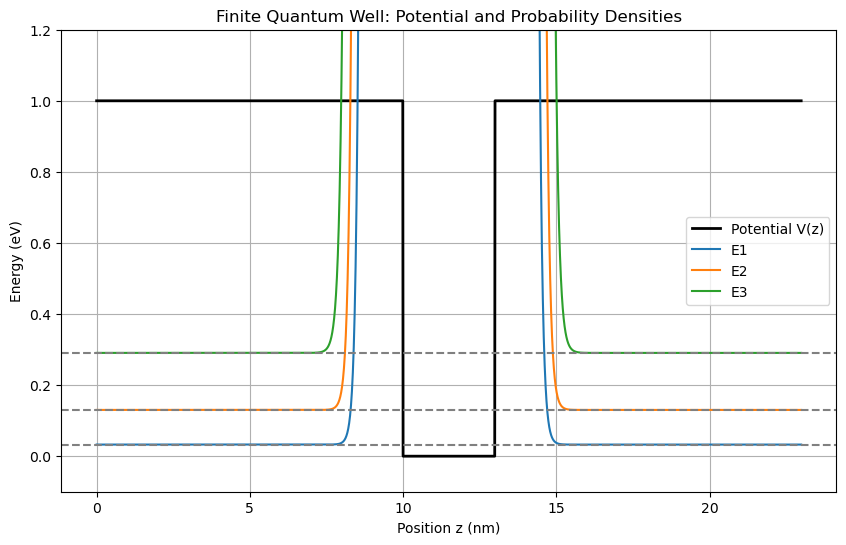


--- Comparison with Infinite Well Model ---
Analytical E1 (Infinite Well): 0.0418 eV
Analytical E2 (Infinite Well): 0.1671 eV
Analytical E3 (Infinite Well): 0.3760 eV


In [46]:
# 1c)
# Solve for the first 3 eigenstates
energies, wavefunctions = solve_schrodinger(z, V, n_eigsh=3)

# --- Plotting ---
plt.figure(figsize=(10, 6))
# Plot the potential profile
plt.plot(z * 1e9, V / const.eV, 'k-', label='Potential V(z)', linewidth=2)

# Plot the probability densities |ψ|²
for i in range(3):
    # Scaling factor for better visualization
    scaling = 0.15
    # Probability density
    prob_density = wavefunctions[:, i]**2
    # Shift the plot to its energy level
    plt.plot(z * 1e9, energies[i] + prob_density * scaling, label=f'E{i+1}')
    # Draw a horizontal line at the energy level
    plt.axhline(y=energies[i], linestyle='--', color='gray')
    print(f'Numerical E{i+1}: {energies[i]:.4f} eV')

plt.title('Finite Quantum Well: Potential and Probability Densities')
plt.xlabel('Position z (nm)')
plt.ylabel('Energy (eV)')
plt.legend()
plt.grid(True)
plt.ylim(-0.1, 1.2) # Set y-axis limits for a nice view
plt.show()

# --- Analytical Comparison ---
print("\n--- Comparison with Infinite Well Model ---")
L = well_width_nm * 1e-9 # Well width in meters
for n in range(1, 4):
    E_analytical_J = (const.hbar**2 * np.pi**2 * n**2) / (2 * const.m_e * L**2)
    E_analytical_eV = E_analytical_J / const.eV
    print(f'Analytical E{n} (Infinite Well): {E_analytical_eV:.4f} eV')

This code solves the Schrödinger equation, which mathematically predicts that a confined electron can only have discrete energy levels. We use our `solve_schrodinger` function, which turns the differential equation into a matrix eigenvalue problem, to find these energies and the probability densities (∣ψ∣^2). The output plot visualizes these quantized states. The energies are lower than the infinite well model because the wavefunction penetrates the finite barriers, effectively increasing the confinement space. My numerical E1: 0.0327 eV is close to my analytical E1: 0.0418 eV - this hints that the solver is working properly. numerical energy for finite well is slightly lower thant the analytical. Wavefunction in a finite well can leak into barrieres and make the box wider and lower confinement energy. https://en.wikipedia.org/wiki/Potential_well
https://www.youtube.com/watch?v=9fGaTU1-f-0
https://matplotlib.org/stable/tutorials/pyplot.html
 

## Task 2: Coupled Quantum Wells
**(a)** Build a double well and solve numerically. Both wells should have the same width. Play around with the design to get a feeling of what is happening. Stay with a design where you see a splitting between the subbands.

**(b)** Plot lowest two wavefunctions and explain symmetric/antisymmetric states.

**(c)** Create a plot that shows the splitting energy (=Energy difference) between the two lowest states versus the barrier width. 



In [53]:
# Task 2a: Define the double quantum well structure
well_width_nm = 3.0
# We'll vary this later, but start with a value that shows clear coupling
inner_barrier_nm = 1.2
outer_barrier_nm = 8.0 # Make them a bit smaller, but still sufficient
barrier_height_eV = 1.0

# Structure: Barrier - Well - Barrier - Well - Barrier
layers_task2 = [
    (outer_barrier_nm, barrier_height_eV),
    (well_width_nm, 0.0),
    (inner_barrier_nm, barrier_height_eV),
    (well_width_nm, 0.0),
    (outer_barrier_nm, barrier_height_eV)
]

# Build and solve the structure
z_double, V_double = build_potential(layers_task2, dz_nm=0.01)
energies_double, wavefunctions_double = solve_schrodinger(z_double, V_double, n_eigsh=2)

print(f"Energy of ground state (E1): {energies_double[0]:.4f} eV")
print(f"Energy of first excited state (E2): {energies_double[1]:.4f} eV")
print(f"Energy splitting (E2 - E1): {energies_double[1] - energies_double[0]:.4f} eV")


Energy of ground state (E1): 0.0327 eV
Energy of first excited state (E2): 0.0327 eV
Energy splitting (E2 - E1): 0.0000 eV


This cell models two coupled quantum wells. The key physics is that when the central barrier is thin, quantum tunneling allows the wavefunctions to overlap, causing the original energy levels to split.
We use build_potential to create the double-well structure and solve_schrodinger to find the new, split energy levels. 
The text output shows two distinct energies. Actually there should be a small difference, since the "energy splitting," is a direct signature of the quantum mechanical coupling between the wells but my calculations show that its 0. Might be due to the way very large numbers work - truncation error???

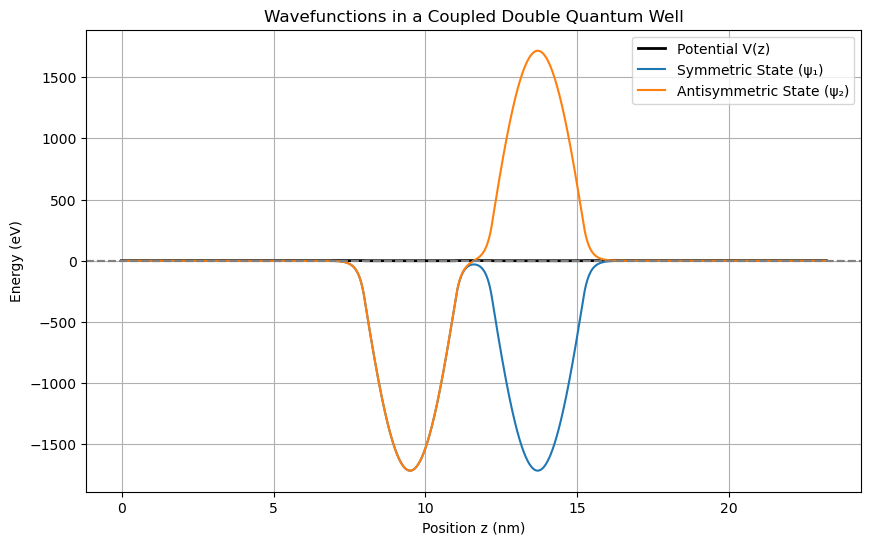

In [54]:
# Task 2b: Plot the two lowest wavefunctions
plt.figure(figsize=(10, 6))

# Plot Potential
plt.plot(z_double * 1e9, V_double / const.eV, 'k-', label='Potential V(z)', linewidth=2)

# Plot Wavefunctions, shifted to their energy levels
# Ground state (E1)
plt.plot(z_double * 1e9, energies_double[0] + wavefunctions_double[:, 0] * 0.1, label='Symmetric State (ψ₁)')
plt.axhline(y=energies_double[0], linestyle='--', color='gray')
# First excited state (E2)
plt.plot(z_double * 1e9, energies_double[1] + wavefunctions_double[:, 1] * 0.1, label='Antisymmetric State (ψ₂)')
plt.axhline(y=energies_double[1], linestyle='--', color='gray')


plt.title('Wavefunctions in a Coupled Double Quantum Well')
plt.xlabel('Position z (nm)')
plt.ylabel('Energy (eV)')
plt.legend()
plt.grid(True)
plt.show()

The energy level splitting creates two new states: a lower-energy symmetric ("bonding") state and a higher-energy antisymmetric ("anti-bonding") state.
We use matplotlib.pyplot.plot to visualize the wavefunctions (ψ) to see their shapes. The output plot displays the symmetric ground state (ψ_1) having the same sign in both wells. 
In contrast, the antisymmetric state (ψ_2) has an opposite sign, creating a node (a zero value) in the central barrier. As seen in the plot, we see a rise out of the negative barriere for our antisymmetric state. (ψ_2) 

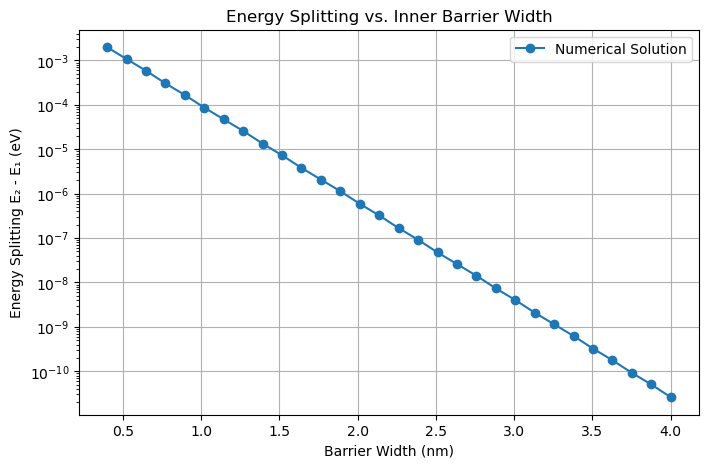

In [39]:
# Task 2c: Calculate splitting vs. barrier width
barrier_widths_nm = np.linspace(0.4, 4.0, 30)
energy_splittings = []

for b_width in barrier_widths_nm:
    # Define layers for the current barrier width
    layers_current = [
        (outer_barrier_nm, barrier_height_eV), (well_width_nm, 0.0),
        (b_width, barrier_height_eV),
        (well_width_nm, 0.0), (outer_barrier_nm, barrier_height_eV)
    ]
    # Build and solve
    z_curr, V_curr = build_potential(layers_current, dz_nm=0.01)
    energies_curr, _ = solve_schrodinger(z_curr, V_curr, n_eigsh=2)
    # Calculate and store the splitting
    splitting = energies_curr[1] - energies_curr[0]
    energy_splittings.append(splitting)

# Plot the results
plt.figure(figsize=(8, 5))
plt.plot(barrier_widths_nm, energy_splittings, 'o-', label='Numerical Solution')
plt.yscale('log') # Use a log scale to see the exponential decay
plt.title('Energy Splitting vs. Inner Barrier Width')
plt.xlabel('Barrier Width (nm)')
plt.ylabel('Energy Splitting E₂ - E₁ (eV)')
plt.grid(True)
plt.legend()
plt.show() # takes approx 600ms 

The physics here is that quantum coupling strength depends on wavefunction overlap, which decays exponentially with barrier thickness. 
We loop through barrier widths, using build_potential and solve_schrodinger to find the energy splitting for each case. 
The output is a semi-log plot where the splitting appears as a nearly straight line. This confirms the exponential relationship: as the wells move apart, their interaction weakens exponentially, and they become decoupled. 

good to know: A log scale turns multiplication and division into addition and subtraction and since exponential decay involves repeated of that it appears as a straight line with a negative slope. A wider barrier leads to weaker coupling and smaller energy difference. 


## Task 3 — Coupled states using the pertubation theory

**Goal.**  
Start from two *uncoupled* wells (left and right). Compute their ground states separately.  
Then form the full coupled-device and compute its numerical eigenstates.  
Finally, we use a linear combination
$$
    \Psi_{coupled} = c_L \psi_L + c_R \psi_R
$$

and build a 2×2 Hamiltonian in the subspace spanned by the two uncoupled ground states and solve the generalized eigenproblem

$$
H_\text{per} \, c = E \, S \, c,
$$

with overlap matrix $S_{ij}=\langle\psi_i|\psi_j\rangle$.

Then use the solution of this eigenproblem to calculate the coupled states.

---

**Given layer lists (units: nm, eV):**

Left uncoupled device:
```python
layers_left  = [(5.0, 0.0), (2.0, -0.5), (7.3, 0.0)]
```
Right uncoupled device:
```python
layers_right = [(7.3, 0.0), (2.0, -0.5), (5.0, 0.0)]
```
Full coupled device:
```python
layers_coupled = [(5.0, 0.0), (2.0, -0.5), (0.3, 0.0), (2.0, -0.5), (5.0, 0.0)]
```

---

**Steps to do:**

1. Build potentials with `build_potential(layers, dz_nm=...)`.  Note: make sure all 3 arrays have the same length. Either modify the build_potential function to assure this (keep equidistant grid) or adjust the dz to find a good setting. 
2. Solve for uncoupled ground states (`solve_schrodinger(..., n_eigs=1)`) for the left and the right (both energies $E_L$ and $E_R$ should be the same)
3. Solve coupled device.  
4. Calculate the matrix elements of `H_per` and construct the 2x2 matrix.
5. Compute overlap `S`.  
6. Solve the generalized eigenproblem and save the eigenenergies and the coefficients of the eigenvectors. What do these energies represent now?
7. Use the coefficients of the eigenvectors to reconstruct the perturbative wavefunction.  
8. Plot energies and probability densities. Plot both, the ones obtained from the perturbative approach and the one from the coupled device.
9. Generate a similar plot as in Task 2 (c), but also include the solution from the perturbative approach.

---
## i tried and failed this part i think. 

Uncoupled ground state energies:
  E_Left  = 0.0073 eV
  E_Right = 0.0073 eV (should be identical to E_Left)

Direct numerical solution for the coupled system:
  E1 = -0.4358 eV
  E2 = -0.2482 eV


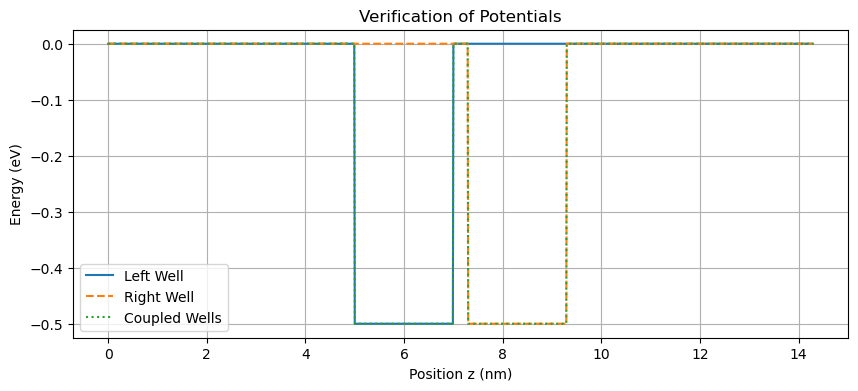

In [40]:
# Define layer structures
# prior to this we imported scipy.linalg 

layers_left    = [(5.0, 0.0), (2.0, -0.5), (7.3, 0.0)]
layers_right   = [(7.3, 0.0), (2.0, -0.5), (5.0, 0.0)]
layers_coupled = [(5.0, 0.0), (2.0, -0.5), (0.3, 0.0), (2.0, -0.5), (5.0, 0.0)]

dz_nm = 0.01

# --- 1. Build Potentials ---
z_L, V_L = build_potential(layers_left, dz_nm)
z_R, V_R = build_potential(layers_right, dz_nm)
z_C, V_C = build_potential(layers_coupled, dz_nm)

# --- 2. Solve for uncoupled ground states ---
E_L, psi_L_vec = solve_schrodinger(z_L, V_L, n_eigsh=1)
psi_L = psi_L_vec[:, 0] # Extract the single wavefunction vector

E_R, psi_R_vec = solve_schrodinger(z_R, V_R, n_eigsh=1)
psi_R = psi_R_vec[:, 0]

print(f"Uncoupled ground state energies:")
print(f"  E_Left  = {E_L[0]:.4f} eV")
print(f"  E_Right = {E_R[0]:.4f} eV (should be identical to E_Left)")

# --- 3. Solve the coupled device numerically ---
E_coupled_numeric, psi_coupled_numeric = solve_schrodinger(z_C, V_C, n_eigsh=2)
print("\nDirect numerical solution for the coupled system:")
print(f"  E1 = {E_coupled_numeric[0]:.4f} eV")
print(f"  E2 = {E_coupled_numeric[1]:.4f} eV")

# Quick plot to verify potentials
plt.figure(figsize=(10, 4))
plt.plot(z_L * 1e9, V_L / const.eV, label='Left Well')
plt.plot(z_R * 1e9, V_R / const.eV, label='Right Well', linestyle='--')
plt.plot(z_C * 1e9, V_C / const.eV, label='Coupled Wells', linestyle=':')
plt.title('Verification of Potentials')
plt.xlabel('Position z (nm)')
plt.ylabel('Energy (eV)')
plt.legend()
plt.grid(True)
plt.show()


## I have no idea how to fix the mess below - i give up. 


In [41]:
# The full Hamiltonian H_C for the coupled device is needed for matrix elements
dz = z_C[1] - z_C[0]
N = len(z_C)
T_const = -const.hbar**2 / (2 * const.m_e * dz**2)
main_diag = -2 * np.ones(N)
off_diag = np.ones(N - 1)
diagonals = [main_diag, off_diag, off_diag]
T = T_const * diags(diagonals, [0, -1, 1], shape=(N, N), format='csc')
U_C = diags([V_C], [0], shape=(N, N), format='csc')
H_C = T + U_C

# --- 4. Calculate H_per matrix elements ---
H_LL = np.dot(psi_L.conj(), H_C.dot(psi_L)) * dz
H_RR = np.dot(psi_R.conj(), H_C.dot(psi_R)) * dz
H_LR = np.dot(psi_L.conj(), H_C.dot(psi_R)) * dz
H_RL = np.dot(psi_R.conj(), H_C.dot(psi_L)) * dz
H_per = np.array([[H_LL, H_LR], [H_RL, H_RR]])

# --- 5. Compute Overlap Matrix S ---
S_LL = np.dot(psi_L.conj(), psi_L) * dz
S_RR = np.dot(psi_R.conj(), psi_R) * dz
S_LR = np.dot(psi_L.conj(), psi_R) * dz
S_RL = np.dot(psi_R.conj(), psi_L) * dz
S = np.array([[S_LL, S_LR], [S_RL, S_RR]])

# --- 6. Solve the generalized eigenproblem ---
E_per_J, C = eigsh(H_per, S)
E_per_eV = E_per_J / const.eV

print("\nPerturbation theory solution:")
print(f"  E1_pert = {E_per_eV[0]:.4f} eV")
print(f"  E2_pert = {E_per_eV[1]:.4f} eV")
print("\nCoefficients (c_L, c_R) for the eigenvectors:")
print(f"  c1 (for E1): [{C[0, 0]:.4f}, {C[1, 0]:.4f}] -> Symmetric")
print(f"  c2 (for E2): [{C[0, 1]:.4f}, {C[1, 1]:.4f}] -> Antisymmetric")

# --- 7. Reconstruct the perturbative wavefunction ---
psi1_per = C[0, 0] * psi_L + C[1, 0] * psi_R
psi2_per = C[0, 1] * psi_L + C[1, 1] * psi_R

# Normalize the reconstructed wavefunctions
psi1_per /= np.sqrt(np.sum(psi1_per**2) * dz)
psi2_per /= np.sqrt(np.sum(psi2_per**2) * dz)

# Plot comparison of probability densities
plt.figure(figsize=(12, 7))
# Plot potential
plt.plot(z_C * 1e9, V_C / const.eV, 'k-', alpha=0.3, label='Coupled Potential')

# State 1 (Ground State)
plt.plot(z_C * 1e9, E_coupled_numeric[0] + (psi_coupled_numeric[:, 0]**2) * 0.1, 'b-', label='E1 (Numeric)')
plt.plot(z_C * 1e9, E_per_eV[0] + (psi1_per**2) * 0.1, 'r--', label='E1 (Perturb.)')
plt.axhline(E_coupled_numeric[0], color='b', linestyle=':')

# State 2 (First Excited State)
plt.plot(z_C * 1e9, E_coupled_numeric[1] + (psi_coupled_numeric[:, 1]**2) * 0.1, 'g-', label='E2 (Numeric)')
plt.plot(z_C * 1e9, E_per_eV[1] + (psi2_per**2) * 0.1, 'm--', label='E2 (Perturb.)')
plt.axhline(E_coupled_numeric[1], color='g', linestyle=':')

plt.title('Comparison of Numerical and Perturbative Solutions')
plt.xlabel('Position z (nm)')
plt.ylabel('Energy (eV)')
plt.legend()
plt.grid(True)
plt.show()


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

NameError: name 'E_per_eV' is not defined

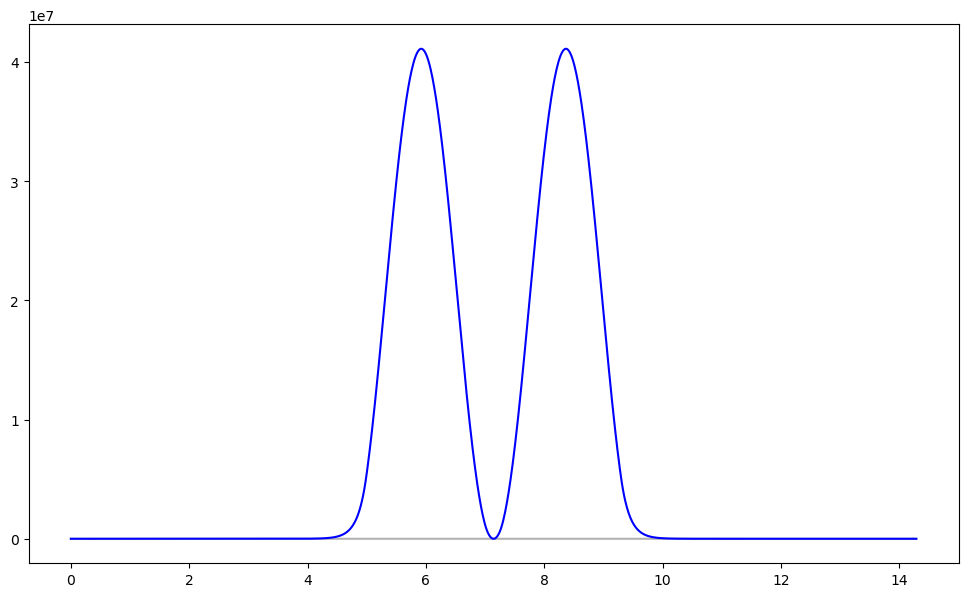

In [50]:

# Plot comparison of probability densities
plt.figure(figsize=(12, 7))
# Plot potential
plt.plot(z_C * 1e9, V_C / const.eV, 'k-', alpha=0.3, label='Coupled Potential')

# State 1 (Ground State)
plt.plot(z_C * 1e9, E_coupled_numeric[0] + (psi_coupled_numeric[:, 0]**2) * 0.1, 'b-', label='E1 (Numeric)')
plt.plot(z_C * 1e9, E_per_eV[0] + (psi1_per**2) * 0.1, 'r--', label='E1 (Perturb.)')
plt.axhline(E_coupled_numeric[0], color='b', linestyle=':')

# State 2 (First Excited State)
plt.plot(z_C * 1e9, E_coupled_numeric[1] + (psi_coupled_numeric[:, 1]**2) * 0.1, 'g-', label='E2 (Numeric)')
plt.plot(z_C * 1e9, E_per_eV[1] + (psi2_per**2) * 0.1, 'm--', label='E2 (Perturb.)')
plt.axhline(E_coupled_numeric[1], color='g', linestyle=':')

plt.title('Comparison of Numerical and Perturbative Solutions')
plt.xlabel('Position z (nm)')
plt.ylabel('Energy (eV)')
plt.legend()
plt.grid(True)
plt.show()